In [48]:
# This is the template for the submission. If you want, you can develop your algorithm in a regular Python script and copy the code here for submission.

# Team members (e-mail, legi):
# zhisun@ethz.ch, 22-958-227
# enjcao@ethz.ch, 22-942-700
# yifzhou@ethz.ch, 22-940-381

In [39]:
import numpy as np
import pandas as pd

from Lilygo.Recording import Recording
from Lilygo.Dataset import Dataset

import os
from os import listdir
from os.path import isfile, join


import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from scipy.stats import entropy
from scipy import signal
from scipy.signal import welch
from scipy.fftpack import fft

from Lilygo.Recording import Recording, data_integrity
from Lilygo.Dataset import Dataset

import xgboost as xgb
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

import joblib

# Local dirs

In [23]:
# Get the path of all traces
dir_data = 'E:\\Sunzhichao\\ETHz\\2223Spring\\Mobile_Health\\data\\'
dir_traces_train = dir_data + 'train\\'
dir_traces_test = dir_data + 'test\\'
dir_labels = dir_data + 'labels\\'
dir_loaded = dir_data + 'Loaded_data\\'
dir_models = dir_data + 'models\\'
# graded traces in ex1
dir_graded = 'data/step_count_grading'

In [31]:
# Get the path of all traces
filenames_train = [join(dir_traces_train, f) for f in listdir(dir_traces_train) if isfile(join(dir_traces_train, f))]
filenames_train.sort()
filenames_graded = [join(dir_graded, f) for f in listdir(dir_graded) if isfile(join(dir_graded, f))]
filenames_graded.sort()
# print(filenames[8])

## Pre-process data

In [10]:
# This function aims to find the component caused by gravity from data, which means the signal around 0 Hz
def get_gravity(data):
    filtered_data = np.zeros_like(data)
    # Parameters in IIR filter
    alpla = [1, -1.979133761292768, 0.979521463540373]
    beta = [0.000086384997973502, 0.00012769995947004, 0.000086384997973502]
    # Formula of IIR filter
    for i in range(2, len(data)):
        filtered_data[i] = alpla[0] * (data[i] * beta[0] + data[i-1] * beta[1] + data[i-2] * beta[2] - filtered_data[i-1] * alpla[1] - filtered_data[i-2] * alpla[2])
    return filtered_data
# This function aims to realize a low-pass filter with cutoff frequency = 1 Hz. Because according to massive amounts of data, the general 
# minimum frequency of human walking is about 1 Hz
def get_lowpass(data):
    filtered_data = np.zeros_like(data)  # filtered_data
    alpla = [1, -1.905384612118461, 0.910092542787947]
    beta = [0.953986986993339, -1.907503180919730, 0.953986986993339]

    for i in range(2, len(data)):
        filtered_data[i] = alpla[0] * (data[i] * beta[0] + data[i-1] * beta[1] + data[i-2] * beta[2] - filtered_data[i-1] * alpla[1] - filtered_data[i-2] * alpla[2])
    return filtered_data
# This funciton aims to realize a high-pass filter with cutoff frequency = 5 Hz. Because according to massive amounts of data, the general 
# maximum frequency of human walking is about 5 Hz
def get_highpass(data):
    filtered_data = np.zeros_like(data)  # filtered_data
    alpla = [1, -1.80898117793047, 0.827224480562408]
    beta = [0.096665967120306, -0.172688631608676, 0.095465967120306]
    
    for i in range(2, len(data)):
        filtered_data[i] = alpla[0] * (data[i] * beta[0] + data[i-1] * beta[1] + data[i-2] * beta[2] - filtered_data[i-1] * alpla[1] - filtered_data[i-2] * alpla[2])
    return filtered_data
def pre_process(data):
    # Find the component caused by gravity from data and remove it from the singanl
    data_gravity = get_gravity(data)
    data_user = data - data_gravity
    # Get user's acceleration along the gravity direction by dot product
    data_acc = data_user * data_gravity
    # Add low pass and high pass filter to reduce noise in signal (possible human walking rate:1 - 5Hz)
    data_filtered = get_highpass(data_acc)
    data_filtered = get_lowpass(data_filtered)
    return data_filtered

## Segment data into windows of same size

In [36]:
def get_segment(trace):
    # Calculate raw magnitude of accelerometer signal
    amagn_acc = [np.sqrt(a**2+trace.data['ay'].values[i]**2+trace.data['az'].values[i]**2)for i, a in enumerate(trace.data['ay'].values)]
    # Pre-process data
    amagn = pre_process(amagn_acc)
    # Calculate window size
    sampling_rate = 200
    std_win = 3 #s
    window_size = round(std_win*sampling_rate)
    segment_trace = [amagn[s:s+window_size] for s in range(0, len(amagn)-window_size, round(window_size/2))]
    return segment_trace

## Get features of each window

In [37]:
# compute energy
def compute_energy(data):
    window_length = len(data)  # length of each window
    # Define the window function (e.g., Hanning or Hamming)
    window = np.hanning(window_length)
    # Apply the window function to the data
    windowed_data = data * window
    # Compute the FFT of the windowed data
    fft_result = np.fft.fft(windowed_data)
    # Compute the squared magnitudes of the FFT components (excluding DC)
    mag_squared = np.abs(fft_result[1:window_length // 2])**2
    # Sum the squared magnitudes and normalize by the window length
    energy = np.sum(mag_squared) / window_length
    # fft_data now contains the energy feature for each window of data
    return energy

# compute entropy
def compute_entropy(data):
    # Assume we have accelerometer data in a 3D array called "data", where each row
    # represents a window of data and each column represents a sensor axis (x, y, z or magnitute)
    window_length = len(data) # length of each window
    # Define the window function (e.g., Hanning or Hamming)
    window = np.hanning(window_length)
    # Apply the window function to the data
    windowed_data = data * window
    # Compute the FFT of the windowed data
    fft_result = np.fft.fft(windowed_data)
    # Compute the magnitudes of the FFT components (excluding DC)
    mag = np.abs(fft_result[1:window_length // 2])
    # Normalize the magnitudes to obtain a probability distribution
    mag_norm = mag / np.sum(mag)
    # Compute the information entropy of the probability distribution
    entropy = -np.sum(mag_norm * np.log2(mag_norm))
    # fft_data now contains the frequency-domain entropy feature for each window of data
    return entropy

def get_features(data):
    # get features from sliding windows
    dc = np.mean(data)
    energy = compute_energy(np.asarray(data))
    entropy = compute_entropy(np.asarray(data))
    return dc, energy, entropy

## Get peaks of filtered data

In [ ]:
# This function aims to find peak locations and corresponding values in the signal with the function signal.find_peaks
def get_peaks(input_signal, prominence):
    peak_locations, _ = signal.find_peaks(input_signal, prominence=prominence)
    peak_values = input_signal[peak_locations]
    return peak_locations, peak_values

## Test on one data

In [74]:
# load activity model
activity_xgb_model = joblib.load('trained_models/activity_xgboost_model_feature.joblib')
# initialize test
stepCounts = []
ids = []

# for i, filename in enumerate(filenames):
filename = filenames_train[2]
print(filename)
trace = Recording(filename, no_labels=True, mute=True)
stepCount = 0

E:\Sunzhichao\ETHz\2223Spring\Mobile_Health\data\train\train_trace_003.json


### Segment data by activity

In [86]:
# get valid activities (more than 60 seconds)
def filter_activity_pred(data):
# filter prediction by 60s
    # Sliding window: 60s
    std_win = 10
    n = round (60 / std_win * 2 - 1)
    data_count = np.zeros(4)
    data_60 = data.copy()
    for s in range(0, len(data) - n, int(n/2+1)):
        # window = 60s 
        windowed_label = data[s : s+n]
        for j in range(n): 
            # Find the label that appears the most
            for k in range(4):
                if windowed_label[j] == k:
                    data_count[k]+=1
        label_argmax = np.where(data_count == np.max(data_count))
        if len(label_argmax)==1:
            data_60[s : s+n] = np.argmax(data_count)
    return data_60

In [82]:
# Get time stamp for each valid activity
# Function to calculate the starting and ending time of each valid activity period
def calculate_activity_periods(activity_list):
    activity_periods = []
    start_frame = 0
    end_frame = start_frame
    prev_activity = activity_list[0]
    for i in range(1, len(activity_list)):
        if activity_list[i] == prev_activity:
            end_frame = i
        else:
            if prev_activity != 0 and (end_frame - start_frame) >= 55:
                activity_periods.append((start_frame, end_frame, prev_activity))
            start_frame = i
            end_frame = start_frame
            prev_activity = activity_list[i]
    if prev_activity != 0 and (end_frame - start_frame) >= 55:
        activity_periods.append((start_frame, end_frame, prev_activity))
    return activity_periods

In [88]:

# get segment data
segment_trace = get_segment(trace)
# add feature extraction
num_features = 3
featured_trace = np.zeros((np.shape(segment_trace)[0], num_features))
for i in range(np.shape(segment_trace)[0]):
    featured_trace[i,] = get_features(segment_trace[i])
# Create the XGBoost DMatrix object for the test data
dtest = xgb.DMatrix(featured_trace)

# Make predictions on the test set and evaluate the model
y_pred = activity_xgb_model.predict(dtest)

TODO: Segment window size to 3s, overlapping 50%, calculate |max - min|, and decide prominence

[0.00000000e+00 5.25453972e-03 1.05090794e-02 ... 3.16265491e+02
 3.16270745e+02 3.16276000e+02]
Location: 2, StepCount: 821


c:\Users\szzcc\.conda\envs\mhealth23\lib\site-packages\ipykernel_launcher.py:54: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "y+" (-> color='y'). The keyword argument will take precedence.


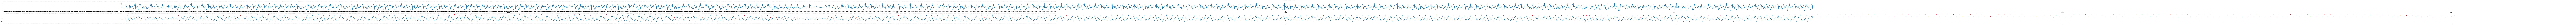

In [78]:
# Your algorithm goes here
# Make sure, you only use data from the LilyGo Wristband, namely the following 10 keys (as in trace.data[key]):
# 3-axis accelerometer: key in [ax, ay, az]
# 3-axis gyro: key in [gx, gy, gz]
# 3-axis magnetometer: key in [mx, my, mz]
# IMU temperature: key==temperature

# Get the original data from Lilygo -----------------------------------------------------------------------
# Get accelerator data
trace = Recording(filename, no_labels=True, mute=True)
ax = trace.data['ax']
ay = trace.data['ay']
az = trace.data['az']
# Get time stamp and sampling rate
timestamp_raw = ax.timestamps
print(timestamp_raw)
timestamp_ms = timestamp_raw*1000
sampling_rate = len(timestamp_raw)/timestamp_raw[-1]

# Calculate raw magnitude of accelerometer signal
amagn = [np.sqrt(a**2+ay.values[i]**2+az.values[i]**2)for i, a in enumerate(ax.values)]
trace.data['amagn'] = Dataset.fromLists('Accelerometer magnitude', amagn, timestamp_ms)


# Filter the signal to get more accurate results -----------------------------------------------------------
# Find the component caused by gravity from data and remove it from the singanl
data_gravity = get_gravity(amagn)
data_user = amagn - data_gravity
# Get user's acceleration along the gravity direction by dot product
data_a = data_user * data_gravity
# Add low pass and high pass filter to reduce noise in signal (possible human walking rate:1 - 5Hz)
data_filtered = get_highpass(data_a)
data_filtered = get_lowpass(data_filtered)
# Use convolution to reduce noise in signal again
filter_window_size = 40
data_filtered = np.convolve(data_filtered, np.ones((filter_window_size,))/filter_window_size, mode='valid')


# Find peaks in the filtered signal and realize our stepcount -----------------------------------------------
# TODO: modify prominence
prominence = 0.15
peak_locations, _ = get_peaks(data_filtered, prominence)
stepCount = len(peak_locations)


# Visualize the original signal, filtered signal and detected peaks -----------------------------------------
title = "Location: " + str(trace.labels['board_loc']) + ", StepCount: " + str(stepCount)
# title = "StepCount: " + str(stepCount)
print(title)
fig, axes1 = plt.subplots(2,1, figsize=(600, 5)) #figsize is width, height
axes1[0].set_title(title)
axes1[0].plot(data_user, alpha=1, label="original")
axes1[1].plot(data_filtered, alpha=1, label="Filtered mag")
axes1[1].plot(peak_locations, data_filtered[peak_locations], 'y+', color="red", label="Peak Locations")


# Append your calculated step counts and the id of the trace to the corresponding array
stepCounts.append(stepCount)
ids.append(filename.split('_')[1][:2])

In [56]:
# Write the detected step counts into a .csv file to then upload the .csv file to Kaggle
# When cross-checking the .csv file on your computer, we recommend using the text editor and NOT excel so that the results are displayed correctly
# IMPORTANT: Do NOT change the name of the columns ('Id' and 'Predicted') of the .csv file
df = pd.DataFrame({'Id':ids,'Predicted':stepCounts})
df.to_csv('./submission.csv', index=False)